<a href="https://colab.research.google.com/github/axle217/ML4HEP-Zakopane2022/blob/main/exercise/top_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_This notebook is part of the material for the [Tutorials for ML4HEP](https://gitlab.com/hepcedar/mcnet-schools/zakopane-2022) session._

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ramonpeter/ML4HEP-Tutorial/blob/main/exercise/top_tagging.ipynb)

# Top-Tagging with Neural Networks

### Importing the libraries

In [1]:
# NN and data structures
import tensorflow as tf
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Part 1 - Data Preprocessing (don't change)

### Download the datasets
We load datasets for training (100k), validation (30k) and testing (30k).

In [2]:
!curl https://www.dropbox.com/s/abd8xntlaorzzvy/train_img.h5?dl=1 -L -o train_img.h5
!curl https://www.dropbox.com/s/cmxe03vjfzhm70i/val_img.h5?dl=1 -L -o val_img.h5
!curl https://www.dropbox.com/s/csxe65ykvmomxcs/test_img.h5?dl=1 -L -o test_img.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   129  100   129    0     0    536      0 --:--:-- --:--:-- --:--:--   537
100    17  100    17    0     0     17      0  0:00:01 --:--:--  0:00:01     0
100 54.7M  100 54.7M    0     0  16.9M      0  0:00:03  0:00:03 --:--:-- 34.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   127  100   127    0     0    319      0 --:--:-- --:--:-- --:--:--   319
100    17  100    17    0     0     16      0  0:00:01  0:00:01 --:--:--    16
100 16.2M  100 16.2M    0     0  7167k      0  0:00:02  0:00:02 --:--:-- 13.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   128  100   128    0     0    370      0 --:--:

### Load the data and reshape


In [3]:
def get_dataset(name):
    raw_data = pd.read_hdf(name, "table").iloc[:, :].values
    images, labels = raw_data[:,:-2].reshape((-1,40,40,1)), raw_data[:,-2]
    return images, labels

In [4]:
# Load the training set and check shape
train_images, train_labels = get_dataset("train_img.h5")
print(train_images.shape)

(100000, 40, 40, 1)


In [5]:
# Load validation set and check shape
val_images,val_labels = get_dataset("val_img.h5")
print(val_images.shape)

# Load test set and check shape
test_images, test_labels = get_dataset("test_img.h5")
print(test_images.shape)

(30000, 40, 40, 1)
(30000, 40, 40, 1)


### Visualize the Jet images

We first have a look into some random single Jet images from the validation set.

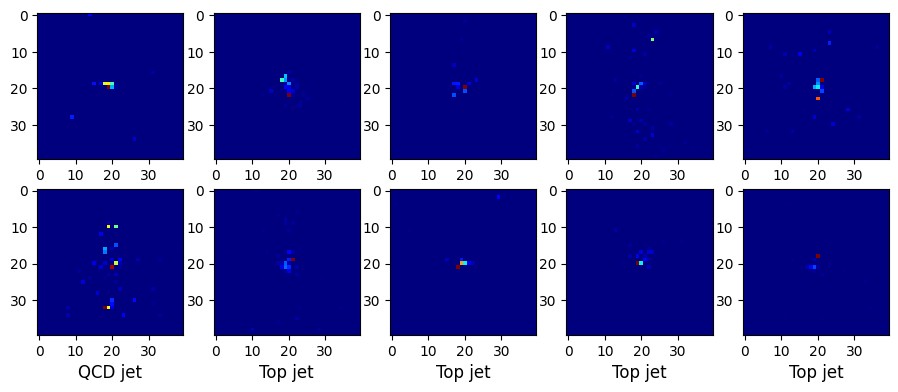

In [6]:
# Plot
classes = ["Top jet", "QCD jet"]
plt.figure(figsize=(11,11))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.yticks([0, 10, 20, 30, 40])
    plt.xticks([0, 10, 20, 30, 40])
    plt.grid(False)
    plt.imshow(val_images[i].squeeze(), cmap=cm.jet)
    plt.xlabel(classes[int(val_labels[i])], fontsize = 12)
plt.show()

We can also have a look into an average Top and QCD jet (10k average):

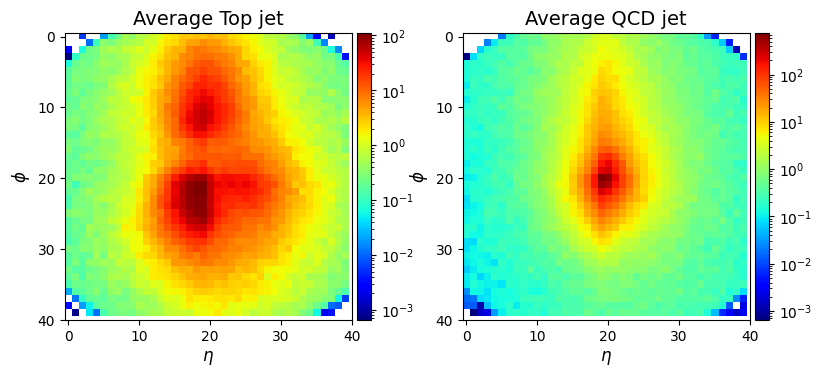

In [7]:
# Get signal and background images
sig = val_labels > 0
sig_images = val_images[sig]
bg_images = val_images[~sig]
k = 10000 # number of jet images averaged over

# calculate average jet image
average_sig = np.sum(sig_images[:k],axis=0)
average_bg = np.sum(bg_images[:k],axis=0)
average = [average_sig, average_bg]
label = ["Average Top jet", "Average QCD jet"]

# Plotting
fig, axs = plt.subplots(1,2, figsize=(8,4), gridspec_kw={'wspace' : 0.3})
plt.subplots_adjust(left=0.07, right=0.95, top=0.96, bottom=0.05)
for i in range(2):
    axs[i].grid(False)
    im = axs[i].imshow(average[i].squeeze(), cmap=cm.jet, norm=colors.LogNorm())
    axs[i].set_title(label[i], fontsize = 14)
    axs[i].set_xlabel(r'$\eta$', fontsize = 12)
    axs[i].set_ylabel(r'$\phi$', fontsize = 12)
    axs[i].set_yticks([0, 10, 20, 30, 40])
    axs[i].set_xticks([0, 10, 20, 30, 40])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[i].set_aspect('equal', adjustable='box')
plt.show()

## Part 2 - Building the Model

Needed parts:
- Input layer (if [Functional API](https://keras.io/guides/functional_api/)) or initilize [sequential model](https://keras.io/guides/sequential_model/)
- Add combination of [convolutions](https://keras.io/api/layers/convolution_layers/) and [pooling](https://keras.io/api/layers/pooling_layers/) layers (for `CNN` only)
- [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) + [Fully Connected](https://keras.io/api/layers/core_layers/dense/) layers
- Output layer with apropriate activation function



### MLP/CNN Model

In [9]:
# Define the CNN model
model = tf.keras.Sequential()

# Input layer
model.add(tf.keras.Input(shape=(40, 40, 1)))

# Convolutional layers with pooling
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten and add dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 38, 38, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 17, 17, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203,329 (794.25 KB)

 Trainable params: 203,329 (794.25 KB)

 Non-trainable params: 0 (0.00 B)

## Part 3 - Training the model

### Compiling the Model

Check the [model.compile](https://keras.io/api/models/model_training_apis/#compile-method) function.  
- Define some `optimizer` and choose choose `binary-crossentropy` loss.
- Use `accuracy` as metric

In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Train on the training set and evaluate on the validation set

- Use the Keras built-in [model.fit](https://keras.io/api/models/model_training_apis/#fit-method) function.
- Define the number of `epochs`
- Choose an appropriate `batch_size`
- Use the validation set to track possible overfitting

In [11]:
# Train the model
history = model.fit(train_images, train_labels,
                    epochs=10,
                    batch_size=64,
                    validation_data=(val_images, val_labels))


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 191s 121ms/step - accuracy: 0.8552 - loss: 0.3293 - val_accuracy: 0.8898 - val_loss: 0.2672
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 192s 114ms/step - accuracy: 0.8978 - loss: 0.2459 - val_accuracy: 0.9010 - val_loss: 0.2370
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 114ms/step - accuracy: 0.9016 - loss: 0.2369 - val_accuracy: 0.9055 - val_loss: 0.2288
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 114ms/step - accuracy: 0.9065 - loss: 0.2273 - val_accuracy: 0.9069 - val_loss: 0.2263
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 115ms/step - accuracy: 0.9069 - loss: 0.2239 - val_accuracy: 0.9058 - val_loss: 0.2265
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 201s 114ms/step - accuracy: 0.9091 - loss: 0.2195 - val_accuracy: 0.9062 - val_loss: 0.2253
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 178s 114ms/step - accuracy: 0.9128 - loss: 0.2131 - val_accuracy: 0.9085 - val_loss: 0.2214
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 178s 114ms/step - ac

Possibly detect overfitting (val acc << train acc) and adjust training: -> ASK ME

## Part 4 - Plotting the results

Check your model on the test set and do:

- Evaluate and plot the [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) curve,
but use the more common LHC standard (x-axis: Signal efficiency = true positive rate, y-axis: Background rejection = 1/(false positive rate))
- Calculate the Area Under the Curve ([AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc))
- Compare with random classifier

### Import necessary libraries and test images

In [12]:
from sklearn.metrics import roc_curve, auc

### Determine and plot ROC curve with AUC

938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step


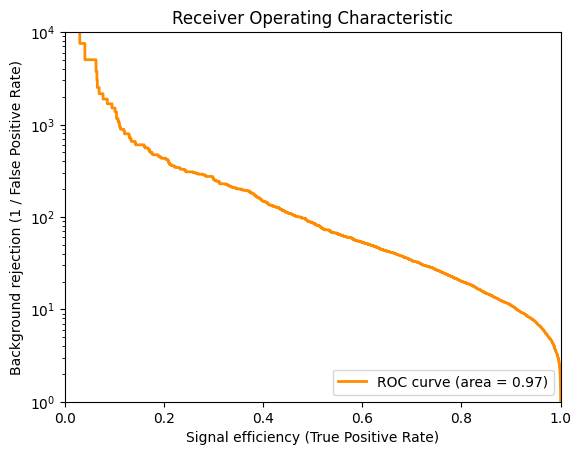

In [14]:
# Predict probabilities on test data
y_pred = model.predict(test_images).ravel()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
roc_auc = auc(fpr, tpr)

# Prevent division by zero by setting fpr values equal to zero to a very small number
fpr_safe = np.where(fpr == 0, 1e-6, fpr)

# Plot ROC curve
plt.figure()
plt.plot(tpr, 1/fpr_safe, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([1.0, 10**4])
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Signal efficiency (True Positive Rate)')
plt.ylabel('Background rejection (1 / False Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

